Датасет содержит информацию о продаже билетов авиакомпании. Каждая строка - уникальная покупка.
ISSUE_DATE	дата покупки
FLIGHT_DATE_LOC	дата совершения перелета
PAX_TYPE	тип пассажиров
REVENUE_AMOUNT	сумма (значения скорректированы, но пропорции сохранены)
ORIG_CITY_CODE	город отправления
DEST_CITY_CODE	город назначения
ROUTE_FLIGHT_TYPE	тип перелета
FFP_FLAG	наличие программы лояльности
SALE_TYPE	способ покупки

Расшифровка значений в полях:
PAX_TYPE	
AD	ADULT
CHD	CHILD
INF	UNDEFINED

ROUTE_FLIGHT_TYPE	
ВВЛ	Внутренние Воздушные Линии
МВЛ	Международные Воздушные Линии
	
Дополнительная информация
данные по кодам аэропортов
https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
список полей:
column_names = ['Airport Name', 'Location', 'Country', 'IATA_Code', 'ICAO_Code', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Timezone Region', 'Type', 'Source']


1. Познакомьтесь с данными.
2. Осуществите предобработку данных.
    - 2.1 Приведите заголовки к удобному виду.
    - 2.2 Проверьте типы данных.
    - 2.3 Обработайте пропуски.
    - 2.4 Проверьте наличие дубликатов.
    - 2.5 Исключите нулевые значения в выручке для дальнейшего исследования. 
3. Исследовательский анализ данных:
     - 3.1 Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.
     - 3.2 Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.
     - 3.3 Исследуйте сезонность продаж. Дополнительно проверьте гипотезу о том, что выручка от продаж осенью и зимой отличается. Исследуйте выручку и число продаж по месяцам, проверьте корреляцию.
     - 3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.
     - 3 .5  Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета:
     https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
     - 3.6 Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.

Каждый пункт исследования сопроводите выводами.


In [262]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st

In [263]:
data = pd.read_csv('air_data.csv', sep=';')

In [264]:
data.head()

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08 00:00:00,2022-01-12 00:00:00,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


In [265]:
data.columns = data.columns.str.lower()

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   issue_date         50000 non-null  object
 1   flight_date_loc    50000 non-null  object
 2   pax_type           50000 non-null  object
 3   revenue_amount     50000 non-null  int64 
 4   orig_city_code     49998 non-null  object
 5   dest_city_code     49999 non-null  object
 6   route_flight_type  50000 non-null  object
 7   ffp_flag           19398 non-null  object
 8   sale_type          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


In [267]:
data['issue_date'] = pd.to_datetime(data['issue_date'], format='%Y-%m-%d %H:%M:%S')
data['flight_date_loc'] = pd.to_datetime(data['flight_date_loc'], format='%Y-%m-%d %H:%M:%S')

In [268]:
data['revenue_amount'] = data['revenue_amount'].astype('float64')

In [269]:
data.isna().sum()

issue_date               0
flight_date_loc          0
pax_type                 0
revenue_amount           0
orig_city_code           2
dest_city_code           1
route_flight_type        0
ffp_flag             30602
sale_type                0
dtype: int64

In [270]:
data[data['orig_city_code'].isna() == True]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
2020,2022-02-17,2022-03-22,AD,440.0,NaN,KHV,МВЛ,NaN,ONLINE
8100,2022-05-02,2022-05-11,AD,440.0,NaN,KHV,МВЛ,NaN,OFFLINE


In [271]:
data[data['dest_city_code'].isna() == True]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
47582,2022-05-13,2022-07-28,AD,440.0,KHV,NaN,МВЛ,NaN,OFFLINE


In [272]:
data['ffp_flag'].unique()

array([nan, 'FFP'], dtype=object)

In [273]:
data['ffp_flag'] = data['ffp_flag'].replace('FFP', True)

In [274]:
data = data.dropna(subset=['orig_city_code'])
data = data.dropna(subset=['dest_city_code'])
data['ffp_flag'] = data['ffp_flag'].fillna(False)

/var/folders/g0/lxz8gk8x2bv0n5hs9p6ws6mm0000gn/T/ipykernel_13732/1019405745.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['ffp_flag'] = data['ffp_flag'].fillna(False)


In [275]:
data.isna().sum()

issue_date           0
flight_date_loc      0
pax_type             0
revenue_amount       0
orig_city_code       0
dest_city_code       0
route_flight_type    0
ffp_flag             0
sale_type            0
dtype: int64

In [276]:
data.drop(data.query('revenue_amount == 0').index, inplace = True)

In [277]:
data.reset_index()

,index,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,0,2021-12-07,2022-01-11,AD,200.0,MOW,KGD,ВВЛ,False,ONLINE
1,1,2021-12-31,2022-01-03,AD,610.0,UUS,OVB,ВВЛ,False,OFFLINE
2,2,2021-11-28,2022-01-04,AD,390.0,KGD,MOW,ВВЛ,True,ONLINE
3,3,2021-12-08,2022-01-05,AD,190.0,VOZ,MOW,ВВЛ,False,ONLINE
4,4,2021-12-08,2022-01-12,AD,190.0,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...
49526,49995,2022-06-11,2022-06-22,CHD,480.0,MOW,OMS,ВВЛ,False,ONLINE
49527,49996,2022-06-06,2022-06-20,AD,270.0,LED,MOW,ВВЛ,False,OFFLINE
49528,49997,2022-06-26,2022-06-29,AD,230.0,MOW,KZN,ВВЛ,True,ONLINE
49529,49998,2022-06-26,2022-06-28,AD,270.0,KZN,MOW,ВВЛ,False,OFFLINE


### Исследовательский анализ данных

### Отчет о динамике продаж

Создайте отчет о динамике продаж (выручке). Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.

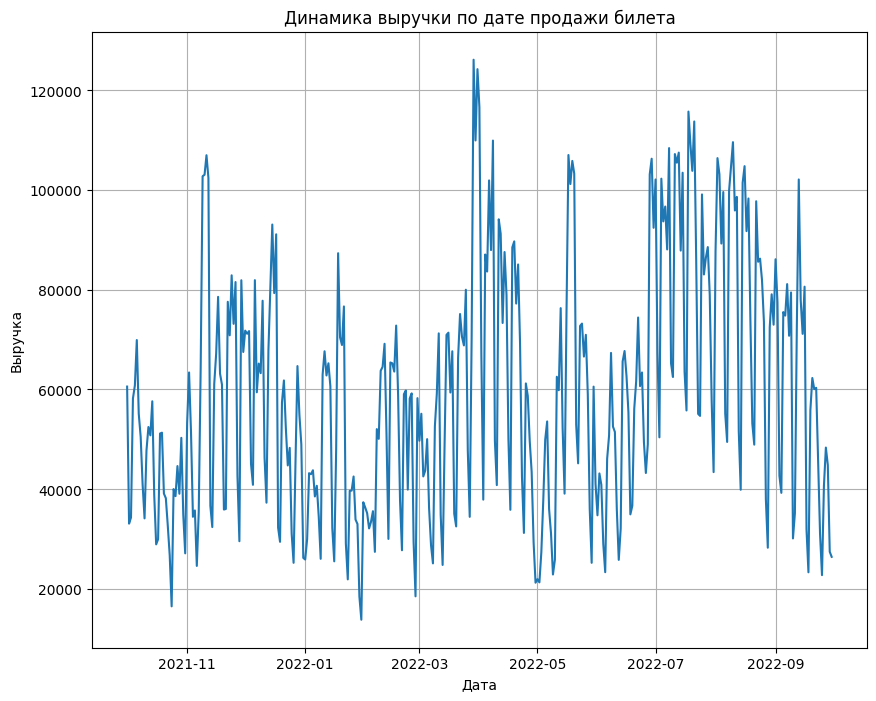

In [278]:
revenue_by_day = data.groupby('issue_date')['revenue_amount'].sum().reset_index()   
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_day, x = 'issue_date', y = 'revenue_amount').set(title = 'Динамика выручки по дате продажи билета', xlabel = 'Дата', ylabel = 'Выручка')
plt.grid()
plt.show()

In [279]:
print('День, в который выручка была наибольшей: ', revenue_by_day.loc[revenue_by_day['revenue_amount'].idxmax()])

День, в который выручка была наибольшей:  issue_date        2022-03-29 00:00:00
revenue_amount               126120.0
Name: 179, dtype: object


In [280]:
print('День, в который выручка была наименьшей: ', revenue_by_day.loc[revenue_by_day['revenue_amount'].idxmin()])

День, в который выручка была наименьшей:  issue_date        2022-01-30 00:00:00
revenue_amount                13830.0
Name: 121, dtype: object


In [293]:
revenue_by_day.sort_values(by='revenue_amount', ascending=False).head(15)

,issue_date,revenue_amount
179,2022-03-29,126120.0
181,2022-03-31,124230.0
182,2022-04-01,116570.0
290,2022-07-18,115720.0
293,2022-07-21,113740.0
180,2022-03-30,109930.0
189,2022-04-08,109910.0
313,2022-08-10,109590.0
291,2022-07-19,109310.0
280,2022-07-08,108400.0


In [294]:
revenue_by_day.query('revenue_amount > 100000').groupby(revenue_by_day['issue_date'].dt.month)['revenue_amount'].count().sort_values(ascending=False)

issue_date
7     11
8      6
5      4
11     4
3      3
4      3
6      2
9      1
Name: revenue_amount, dtype: int64

По всему исследумеому периоду можно заметить несколько сильных колебаний: это колебание с ноября 2021 по январь 2022 года, с марта 2022 по май 2022 года и с июня 2022 по октябрь 2022. При этом, не смотря на то, что самая большая выручка была получена 29 марта 2022 года, составив 126120 у.е., на лето 2022 приходится наибольшее число пиковых значений, превышающих 100000 за день. Так, на июнь пришлось 11 дней, в которые выручка была больше 100 тысяч, а на июль - 6 таких дней. Самая низкая выручка была 30 января: за день она составила 13840 у.е.

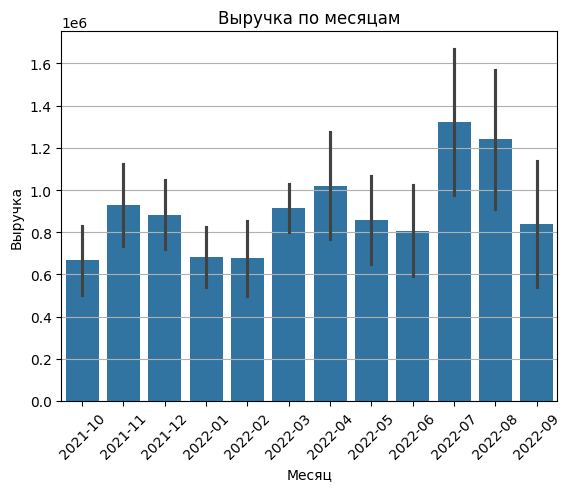

In [283]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'), 'ffp_flag'])['revenue_amount'].sum().reset_index()
plt.grid()
sns.barplot(data = revenue_by_month, x = 'issue_date', y = 'revenue_amount').set(title = 'Выручка по месяцам', xlabel = 'Месяц', ylabel = 'Выручка')
plt.xticks(rotation = 45)
plt.show()

In [284]:
revenue_by_month = data.groupby('issue_date')['revenue_amount'].count().reset_index()
revenue_by_month

,issue_date,revenue_amount
0,2021-10-01,163
1,2021-10-02,93
2,2021-10-03,110
3,2021-10-04,166
4,2021-10-05,166
...,...,...
360,2022-09-26,81
361,2022-09-27,90
362,2022-09-28,69
363,2022-09-29,55


In [285]:
print('День, в который купили больше всего билетов: ', revenue_by_month.loc[revenue_by_month['revenue_amount'].idxmax()])

День, в который купили больше всего билетов:  issue_date        2021-11-12 00:00:00
revenue_amount                    322
Name: 42, dtype: object


In [286]:
print('День, в который купили меньше всего билетов: ', revenue_by_month.loc[revenue_by_month['revenue_amount'].idxmin()])

День, в который купили меньше всего билетов:  issue_date        2022-01-30 00:00:00
revenue_amount                     42
Name: 121, dtype: object


[Text(0.5, 1.0, 'Динамика выручки по дате продажи билета'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Выручка')]

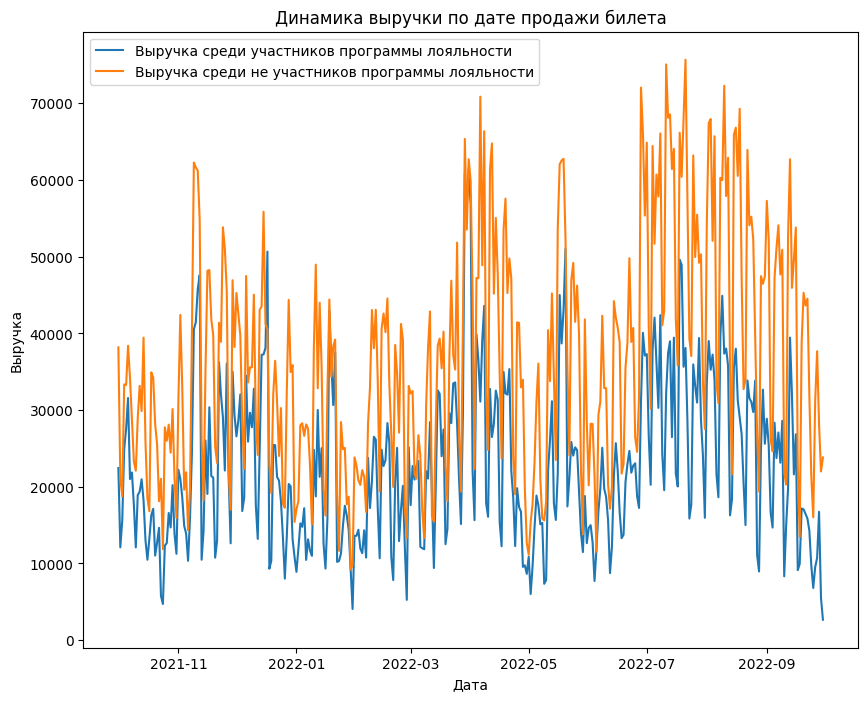

In [287]:
revenue_by_month_ffp = data.query('ffp_flag == True').groupby('issue_date')['revenue_amount'].sum().reset_index()   
revenue_by_month_not_ffp = data.query('ffp_flag == False').groupby('issue_date')['revenue_amount'].sum().reset_index()   
plt.figure(figsize = (10, 8))
sns.lineplot(data = revenue_by_month_ffp, x = 'issue_date', y = 'revenue_amount', label='Выручка среди участников программы лояльности')
sns.lineplot(data = revenue_by_month_not_ffp, x = 'issue_date', y = 'revenue_amount', label='Выручка среди не участников программы лояльности').set(title = 'Динамика выручки по дате продажи билета', xlabel = 'Дата', ylabel = 'Выручка')

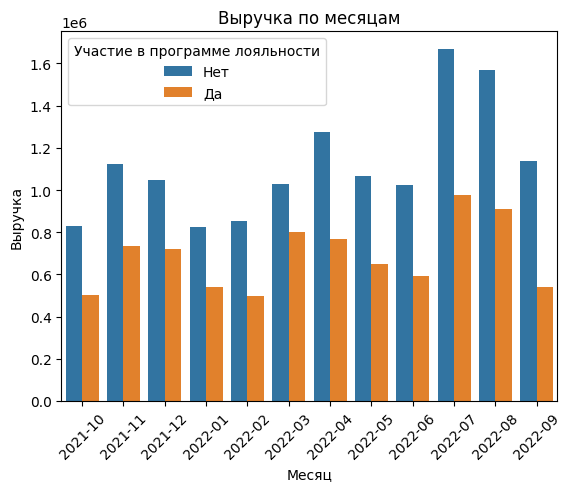

In [288]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'),'ffp_flag'])['revenue_amount'].sum().reset_index()
ax = sns.barplot(data=revenue_by_month,  x='issue_date', y='revenue_amount', hue='ffp_flag', hue_order=[False, True])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Нет', 'Да'], title='Участие в программе лояльности')
plt.xticks(rotation = 45)
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

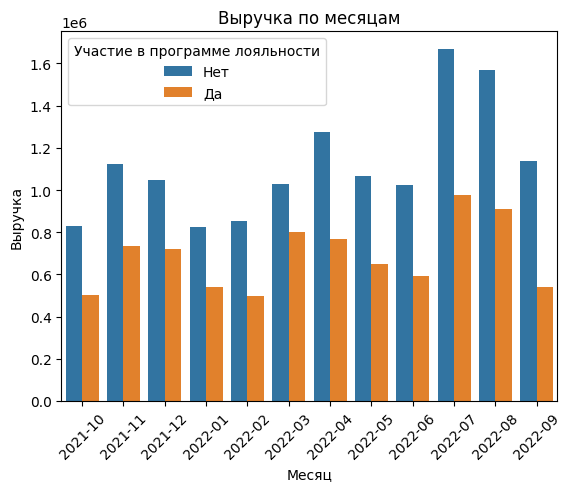

In [289]:
ax = sns.barplot(data=revenue_by_month,  x='issue_date', y='revenue_amount', hue='ffp_flag', hue_order=[False, True])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Нет', 'Да'], title='Участие в программе лояльности')
plt.xticks(rotation = 45)
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.show()

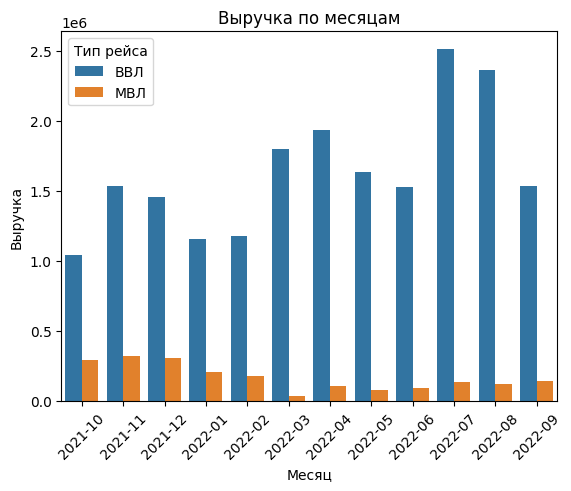

In [290]:
revenue_by_month = data.groupby([data['issue_date'].dt.to_period('M'), 'route_flight_type'])['revenue_amount'].sum().reset_index()
sns.barplot(data = revenue_by_month, x = 'issue_date', y = 'revenue_amount', hue='route_flight_type').set(title = 'Выручка по месяцам', xlabel = 'Месяц', ylabel = 'Выручка', )
plt.xticks(rotation = 45)
plt.legend(title='Тип рейса')
plt.show()

[Text(0.5, 1.0, 'Динамика цены билета по дате его продажи'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Цена билета')]

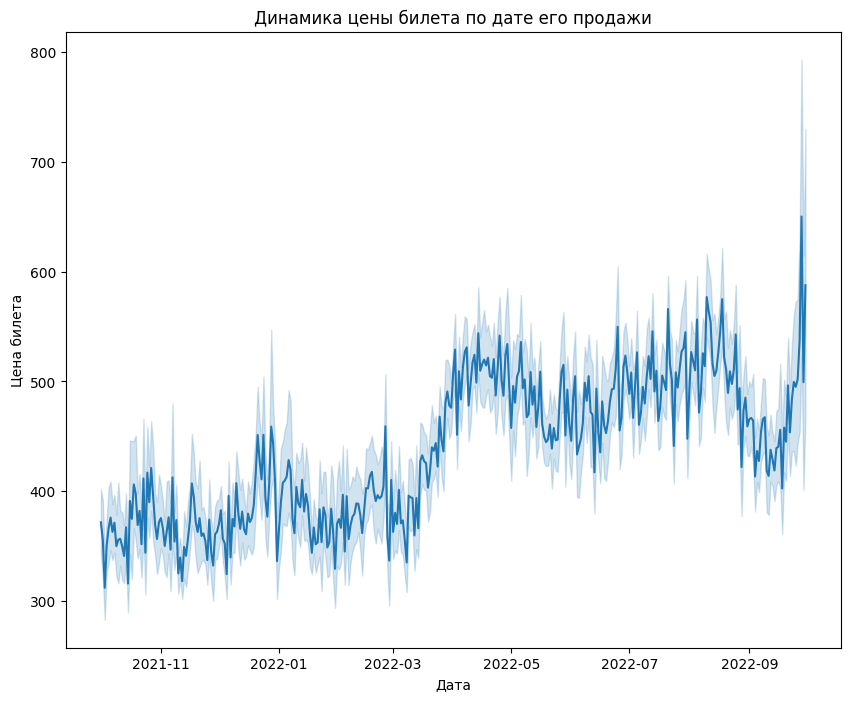

In [291]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = data, x = 'issue_date', y = 'revenue_amount').set(title = 'Динамика цены билета по дате его продажи', xlabel = 'Дата', ylabel = 'Цена билета')

По данному графику можно заметить удорожание билетов: в начале исследуемого периода цена билетов не доходила и до 400, а к концу - превышала 600.